# Адаптивный Корреляционный Фильтр

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pylab
import cv2

Разрешение исходного изображения: (512, 512)


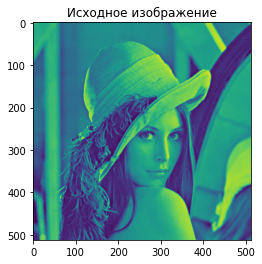

In [2]:
img = cv2.imread('Lenna.png', cv2.IMREAD_GRAYSCALE)
print('Разрешение исходного изображения:', img.shape)

plt.imshow(img)
plt.title('Исходное изображение')
plt.show()

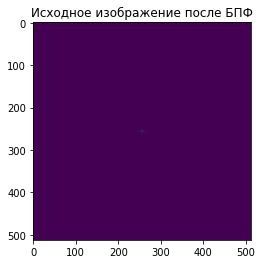

In [3]:
# БПФ картинки
img_fft = np.fft.fft2(img)
# ??? какой-то сдвиг
# (https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html)
img_fft = np.fft.fftshift(img_fft)

plt.imshow(np.abs(img_fft))
plt.title('Исходное изображение после БПФ')
plt.show()

In [4]:
print(img_fft[1:5,1:5])

[[ -792.66123652-333.3653231j    126.64742675+212.05643861j
  -1516.59231176+221.69097153j  -104.39019766+916.31696251j]
 [ -172.70345732 +67.34381935j    98.04022571-455.60786435j
    571.37349808-512.42910431j  -997.30133572-671.81417539j]
 [  -56.28009035+545.53025244j   637.48888731+222.26133121j
    -59.35337953-571.08001001j  -101.80599867-217.78063616j]
 [ -263.113304  +312.52437918j   -89.74642833 +47.56021324j
    542.20100656-665.49512168j  -304.29977861-397.17666856j]]


Добавляем более продвинутую функцию для визуализации преобразования Фурье

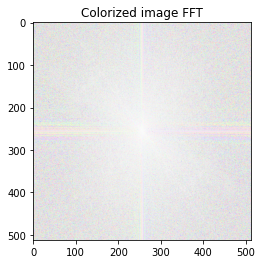

In [5]:
from colorsys import hls_to_rgb


def colorize(z):
    r = np.abs(z)
    arg = np.angle(z) 

    h = (arg + np.pi)  / (2 * np.pi) + 0.5
    l = 1.0 - 1.0 / (1.0 + r ** 0.3)
    s = 0.8

    c = np.vectorize(hls_to_rgb)(h, l, s) # --> кортеж
    c = np.array(c)  # -->  массив формой (3,n,m), а нужно (n,m,3)
    c = c.swapaxes(0, 2) 
    return c


colorized_img_fft = colorize(img_fft)

plt.imshow(colorized_img_fft)
plt.title('Colorized image FFT')
plt.show()

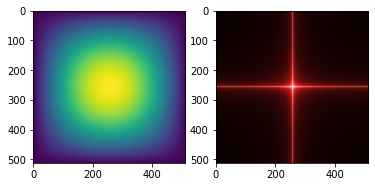

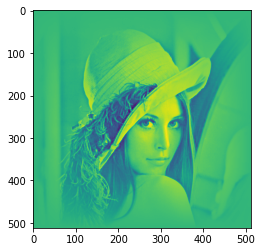

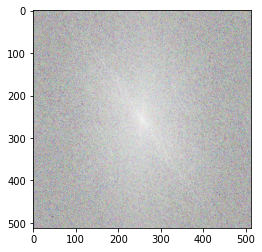

In [6]:
def preprocess(image, verbose=False):
    image = image.astype('float32')
    if verbose:
        print('Исходные значения:\n', image[0:5, 0:5])

    # Логарифм для увеличения чувствительности к тёмным оттенкам
    image = np.log(1 + image)
    if verbose:
        print('Логарифмированные значения:\n', image[0:5, 0:5])

    # Нормализация до среднего арифметического 0 и нормы 1
    mu = np.mean(image)
    sigma = np.std(image - mu)
    image = (image - mu) / sigma
    if verbose:
        print('Нормализованные значения:\n', image[0:5, 0:5])
        print('std = {}, mean = {}'.format(np.std(image), np.mean(image)))

    def sin2dwin(z):
        """ Создаёт маску 'виньетки' для изображения """
        xaxis = np.arange(z.shape[0])
        yaxis = np.arange(z.shape[1])
        x, y = np.meshgrid(xaxis, yaxis)
        wx = np.pi / x.shape[0]
        wy = np.pi / x.shape[1]
        return np.sin(wx * x) * np.sin(wy * y)

    # Добавляем 'виньетку'
    window = sin2dwin(image)
    image *= window
    if verbose:
        print('Результирующие значения:\n', image[0:5, 0:5])

    return image, window


preprocessed_img, window = preprocess(img)

# Визуализируем окно и его спектр
pylab.clf()
pylab.subplot(121)
pylab.imshow(window)

window_fft = np.fft.fft2(window)
window_fft = np.fft.fftshift(window_fft)
colorized_window_fft = colorize(window_fft)

pylab.subplot(122)
pylab.imshow(colorized_window_fft)
pylab.show()

# Визуализируем изображение после предобработки и его спектр
pylab.imshow(preprocessed_img)
pylab.show()

preprocessed_img_fft = np.fft.fft2(preprocessed_img)
preprocessed_img_fft = np.fft.fftshift(preprocessed_img_fft)
colorized_img_fft = colorize(preprocessed_img_fft)

plt.imshow(colorized_img_fft)
plt.show()

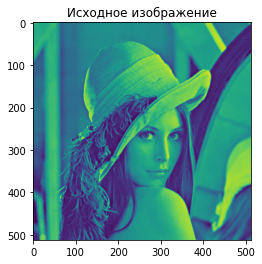

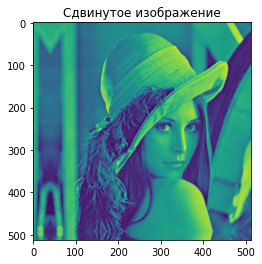

In [7]:
def shift_image(image, shift):
    dx = shift[0]
    dy = shift[1]
    mapmat = np.array([[1, 0, dx], [0, 1, dy]], dtype='float32')
    shifted_image = cv2.warpAffine(
        image,
        mapmat,
        image.shape, 
        flags=cv2.INTER_LINEAR + cv2.WARP_FILL_OUTLIERS, 
        borderMode=cv2.BORDER_REFLECT_101
    )
    return shifted_image


shift = (40, -20)
shifted_img = shift_image(img, shift)

plt.imshow(img)
plt.title('Исходное изображение')
plt.show()

plt.imshow(shifted_img)
plt.title('Сдвинутое изображение')
plt.show()

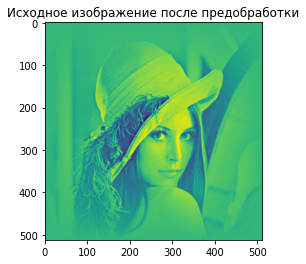

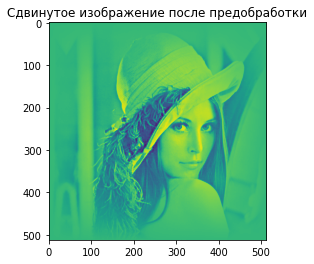

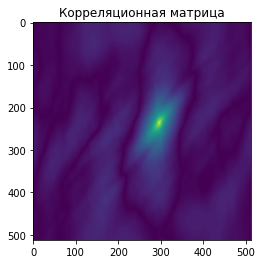

Найденный сдвиг: [-20.  40.]


In [8]:
# Apply preprocess and FFT to original and displaced images
preprocessed_origin_img, _ = preprocess(img)
origin_img_fft = np.fft.fft2(preprocessed_origin_img)

plt.imshow(preprocessed_origin_img)
plt.title('Исходное изображение после предобработки')
plt.show()


preprocessed_shifted_img, _ = preprocess(shifted_img)
shifted_img_fft = np.fft.fft2(preprocessed_shifted_img)

plt.imshow(preprocessed_shifted_img)
plt.title('Сдвинутое изображение после предобработки')
plt.show()


# корреляция между обычным и сдвинутым изображением
correl_fft = shifted_img_fft * np.conj(origin_img_fft)
correl = np.fft.ifft2(correl_fft)
correl = np.fft.fftshift(correl)
correl_view = np.abs(correl)

plt.imshow(correl_view)
plt.title('Корреляционная матрица')
plt.show()

# Определим координаты экстремума
shiftEndPt = np.unravel_index(correl_view.argmax(), correl_view.shape)  # вытаскиваем индекс в двумерном массиве argmax
shiftStartPt = 0.5 * np.array(correl_view.shape)  # координата центра
deteminated_shift = shiftEndPt - shiftStartPt  # сдвиг относительно центра
print('Найденный сдвиг: {}'.format(deteminated_shift))

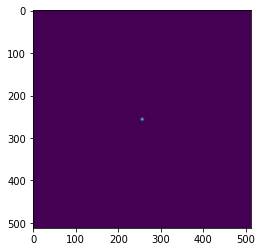

In [9]:
def get_desired_output(image_resolution, sigma=2.0):
    """ Генерирует g с плотным (sigma=2.0) пиком гаусовой формы в центре """
    xaxis = np.arange(image_resolution[0])
    yaxis = np.arange(image_resolution[1])
    x, y = np.meshgrid(xaxis, yaxis)

    center = 0.5 * image_resolution
    norm1 = 1 / np.sqrt(2 * np.pi * sigma)
    norm2 = 1 / (2 * sigma ** 2)
    desired_output = norm1 * np.exp(-(np.square(x - center[0]) + np.square(y - center[1])) * norm2)

    return desired_output


img_res = np.array(img.shape)
desired_output = get_desired_output(img_res)

plt.imshow(desired_output)
plt.show()

(464, 464)


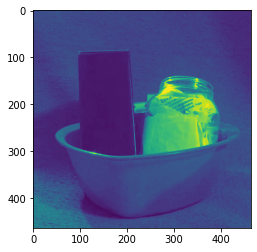

In [10]:
cap = cv2.VideoCapture('test video 464x464.mp4')

retval, first_frame = cap.read()
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

print(first_frame.shape)

plt.imshow(first_frame)
plt.show()

(464, 464)


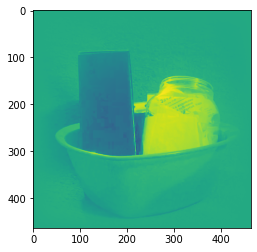

In [11]:
preprocessed_first_frame, _ = preprocess(first_frame)
print(preprocessed_first_frame.shape)

plt.imshow(preprocessed_first_frame)
plt.show()

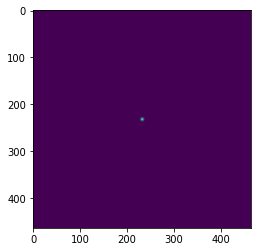

In [12]:
preprocessed_first_frame_res = np.array(preprocessed_first_frame.shape)
desired_output = get_desired_output(preprocessed_first_frame_res)

plt.imshow(desired_output)
plt.show()

In [13]:
desired_output_fft = np.fft.fft2(desired_output)
preprocessed_first_frame_fft = np.fft.fft2(preprocessed_first_frame)
filter_conj_fft = desired_output_fft / preprocessed_first_frame_fft

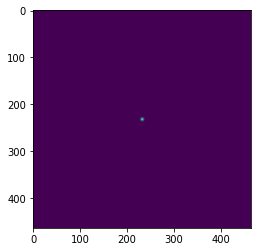

In [14]:
output_fft = preprocessed_first_frame_fft * filter_conj_fft
output = np.fft.ifft2(output_fft)
# output = np.fft.fftshift(output)
output_view = np.abs(output)

plt.imshow(output_view)
plt.show()

In [15]:
print(output_view.max())

0.2820947917738781
